In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FV
import torch.optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from tqdm import tqdm
import os


import lightning as L
from torchmetrics import Accuracy
from lightning.pytorch.loggers import TensorBoardLogger
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchmetrics.image.fid import FrechetInceptionDistance
import optuna
import pickle
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from lightning.pytorch.callbacks import EarlyStopping
VOCAB_SIZE = 192
TRAIN_SET = "data/train.pkl"
TEST_SET = "data/test_no_target.pkl"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = int(os.cpu_count() / 2)
CLASSES_NO = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


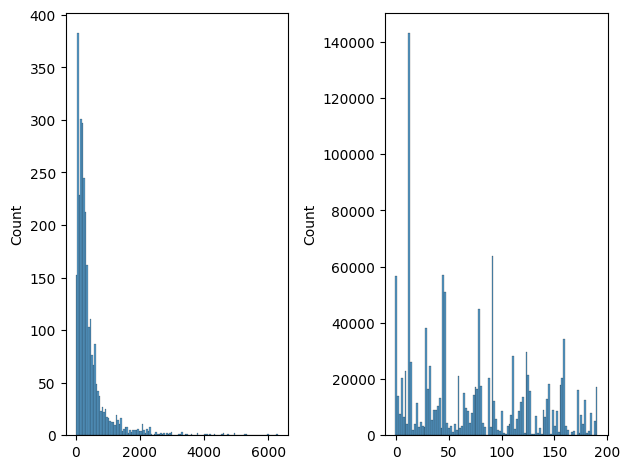

In [8]:
with open("data/train.pkl", "rb") as fh:
    f = pickle.load(fh)
df = [x[0] for x in f]
fig, [ax1, ax2] = plt.subplots(1, 2)
sns.histplot([len(x) for x in df], ax=ax1)
sns.histplot(np.concatenate(df), ax=ax2)
plt.tight_layout()

43

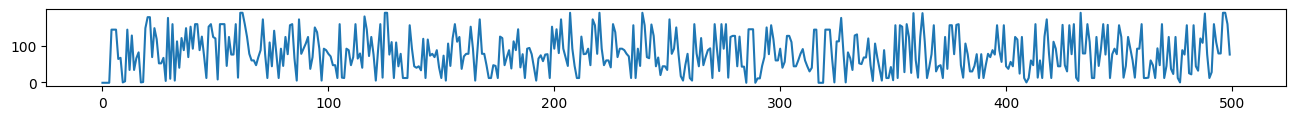

In [35]:
plt.figure(figsize=(16, 1))
sns.lineplot(df[0][:500])
np.count_nonzero(df[0]==-1.0)

In [31]:
class SequenceDataset(Dataset):
    def __init__(self, data, has_labels=True):
        self.data = data
        self.has_labels = has_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.has_labels:
            sequence, label = self.data[idx]
            return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            sequence = self.data[idx]
            return torch.tensor(sequence, dtype=torch.float32)

class SequenceDataModule(L.LightningDataModule):
    def __init__(self, train_file, test_file, batch_size=32, val_split=0.2):
        super().__init__()
        self.train_file = train_file
        self.test_file = test_file
        self.batch_size = batch_size
        self.val_split = val_split

    def setup(self, stage=None):
        with open(self.train_file, 'rb') as f:
            train_data = pickle.load(f)
        with open(self.test_file, 'rb') as f:
            test_data = pickle.load(f)
        
        train_size = int((1 - self.val_split) * len(train_data))
        val_size = len(train_data) - train_size
        train_data, val_data = random_split(train_data, [train_size, val_size])
        self.train_dataset = SequenceDataset(train_data)
        self.val_dataset = SequenceDataset(val_data)
        self.test_dataset = SequenceDataset(test_data, has_labels=False)

    def collate_fn(self, batch):
        if isinstance(batch[0], tuple):
            sequences, labels = zip(*batch)
            sequences = [seq.clone().detach().unsqueeze(-1) for seq in sequences]  # Add extra dimension
            lengths = torch.tensor([len(seq) for seq in sequences])
            sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            return sequences_padded, lengths, torch.tensor(labels, dtype=torch.long)
        else:
            sequences = [seq.clone().detach().unsqueeze(-1) for seq in batch]  # Add extra dimension
            lengths = torch.tensor([len(seq) for seq in sequences])
            sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            return sequences_padded, lengths

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, num_workers=NUM_WORKERS)
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, num_workers=NUM_WORKERS)
dm = SequenceDataModule("data/train.pkl", "data/test_no_target.pkl")
dm.setup()
dt = dm.train_dataloader()
next(iter(dt))

(tensor([[[144.],
          [144.],
          [ 66.],
          ...,
          [  0.],
          [  0.],
          [  0.]],
 
         [[ -1.],
          [ -1.],
          [ -1.],
          ...,
          [  0.],
          [  0.],
          [  0.]],
 
         [[144.],
          [144.],
          [ 64.],
          ...,
          [  0.],
          [  0.],
          [  0.]],
 
         ...,
 
         [[ -1.],
          [ -1.],
          [ -1.],
          ...,
          [  0.],
          [  0.],
          [  0.]],
 
         [[  2.],
          [ 36.],
          [ 68.],
          ...,
          [  0.],
          [  0.],
          [  0.]],
 
         [[  3.],
          [ 41.],
          [156.],
          ...,
          [  0.],
          [  0.],
          [  0.]]]),
 tensor([ 471,  324,  168,   88,  212,  112,  228,  600,  108,  204, 4596,  278,
           67,  416, 1479,  204,  138,    7,  104,  259,  135,  156,  156,  660,
          382,  300, 1612,  333,  297,   60,  231,  273]),
 tensor

In [42]:
import torch
import torch.nn as nn

class RNNModel(L.LightningModule):
    def __init__(self, input_dim, output_dim, trail: optuna.trial.Trial=None, hidden_dim=128, n_layers=2, dropout=0.5, lr=1e-3):
        super(RNNModel, self).__init__()
        self.save_hyperparameters()
        self.trial = trail
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.lstm.flatten_parameters()
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.loss = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x, lengths):
        lengths = lengths.cpu()
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_input)
        hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        out = self.fc(hidden)
        return out

    def training_step(self, batch, batch_idx):
        sequences, lengths, labels = batch
        outputs = self(sequences, lengths)
        loss = self.loss(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences, lengths, labels = batch
        outputs = self(sequences, lengths)
        loss = self.loss(outputs, labels)
        self.log('val_loss', loss)
        if self.trial is not None:
            self.trial.report(loss, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        sequences, lengths = batch
        outputs = self(sequences, lengths)
        _, predicted = torch.max(outputs, 1)
        return predicted


In [43]:
def objective(trial: optuna.trial.Trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    n_layers = trial.suggest_categorical('n_layers', [1, 2, 3])
    dropout = trial.suggest_float("dropout", 0.2, 0.6, log=True)
    
    xp_name = f"dev lr: {learning_rate:.2e}  h: {hidden_dim:<3} l: {n_layers:<3} d: {dropout:.2e}".replace('.', '_').replace(',', '_')
    
    logger = TensorBoardLogger("logs", name="dev", version=xp_name)
    model = RNNModel(1, CLASSES_NO, trail=trial, hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, lr=learning_rate)

    trainer = L.Trainer(max_epochs=40,
                    accelerator="gpu", 
                    logger=logger,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=7, strict=False, verbose=False, mode='min')])
    trainer.fit(model, SequenceDataModule(TRAIN_SET, TEST_SET))
    val_loss = trainer.callback_metrics["val_loss"].item()
    
    return val_loss
optuna.logging.disable_default_handler()
study = optuna.create_study(
            direction="minimize", 
            study_name='simple rnn',
            storage="sqlite:///db.sqlite3",
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(),
            load_if_exists=True
        )

study.optimize(objective, n_trials=5, n_jobs=1)


/home/mszawerd/Learn/ium/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5179657521056344 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | lstm    | LSTM             | 34.3 K
1 | fc      | Linear           | 645   
2 | dropout | Dropout          | 0     
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.140     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mszawerd/Learn/ium/.venv/lib/python3.10/site-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/mszawerd/Learn/ium/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/home/mszawerd/Learn/ium/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24464491063202395 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | lstm    | LSTM             | 530 K 
1 | fc      | Linear           | 2.6 K 
2 | dropout | Dropout          | 0     
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
532 K     Traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [37]:
preds = trainer.predict(model, SequenceDataModule(TRAIN_SET, TEST_SET))
predicted_classes = torch.cat(preds).cpu().numpy()
df = pd.DataFrame(predicted_classes)
df.to_csv('predictions.csv', index=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]